In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import itertools
import geopandas as gpd
import xarray as xr
import regionmask
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from collections import OrderedDict
import sys

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_12666/41488323.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (ca

Data from UEA CRU TS4.07 (1901-2022)

In [2]:
#file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\cru_ts4.07.1901.2022.tmx.dat.nc"
#file2 = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\cru_ts4.07.1901.2022.pre.dat.nc"
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.pre.dat.nc"
file2 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.tmx.dat.nc"

file_paths_list =[file,file2]
monthly_forecast=xr.Dataset()

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)], compat='override')

Data on conflict events from ACLED

In [3]:
#file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\ACLED_1997-01-01-2023-07-18_Somalia.csv"# df = pd.read_csv(file)
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/ACLED_1997-01-01-2023-07-18_Somalia.csv"
df = pd.read_csv(file)

Shapefile with administrative boundaries of Somalia

In [4]:
#path = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\som_adm_ocha_itos_20230308_shp\som_admbnda_adm1_ocha_20230308.shp"
path = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp"
states_gdf = gpd.read_file(path) 

Limit the lat-lon and time

In [5]:
def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [6]:
start_date = '1901-01-01'
end_date = '2022-12-31'

region = monthly_forecast[["pre",'tmx']].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [7]:
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

temp_pre = region.where(region_mask)

temp_pre = temp_pre.groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [8]:
replacement_dict = {0  :  'Awdal',
1    :         'Bakool',
2      :       'Banadir',
3      :         'Bari',
4       :         'Bay',
5        :  'Galgaduud',
6          :      'Gedo',
7          :   'Hiraan',
8   :       'Lower_Juba',
9   :   'Lower_Shabelle',
10  :      'Middle_Juba',
11   : 'Middle_Shabelle',
12    :          'Mudug',
13    :        'Nugaal',
14      :       'Sanaag',
15       :        'Sool',
16        :   'Togdheer',
17   : 'Woqooyi_Galbeed'}

temp_pre['admin1'] = temp_pre['region'].replace(replacement_dict)
df['admin1'] = df['admin1'].str.replace(' ', '_')
temp_pre.drop('region', axis=1, inplace=True)

In [9]:
# Modify event_date column to datetime

df['event_date'] = pd.to_datetime(df['event_date'])
df = df.set_index('event_date') 

conflict = df.groupby([pd.Grouper(freq='M'),"admin1"]).count()
conflict.reset_index(level=[0, 1], inplace=True)
conflict = conflict[['event_date','admin1','year']].rename(columns={'year': 'conflicts','event_date': 'time'})

# Aggregate the datetime objects by month
conf = conflict.groupby([pd.Grouper(key='time', freq='M'),'admin1'])['conflicts'].sum().to_frame()

In [10]:
# Reindex the DataFrame with all dates and districts and fill missing values with 0

dates = conf.index.get_level_values('time').unique()
districts = conf.index.get_level_values('admin1').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts], names=['time', 'admin1'])

conflicts = conf.reindex(all_combinations, fill_value=0).reset_index()    
conflicts = conflicts.sort_values(by=['time', 'admin1'], ascending=[True, True])
conflicts.reset_index(drop=True, inplace=True)

In [11]:
# Add Banadir region with tmx and pre as mean of the neighbouring regions

district1 = 'Lower_Shabelle'  
district2 = 'Middle_Shabelle'  

# Calculate the mean tmx and pre for the neighboring districts
mean_t = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['tmx'].mean()
mean_p = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['pre'].mean()

new_data = pd.DataFrame({ 'admin1': 'Banadir', 'tmx': mean_t, 'pre': mean_p}).reset_index()

# Append the new DataFrame to the original DataFrame
df3 = pd.concat([temp_pre, new_data])

temp_pre = df3.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)

In [12]:
# Only keep month and year in time column in temp_pre and conflicts

temp_pre['time'] = pd.to_datetime(temp_pre['time']).dt.strftime('%Y-%m-%d')
temp_pre['month'] = temp_pre['time'].str[5:7]
temp_pre['month_year'] = temp_pre['time'].str[:7]
conflicts['time'] = conflicts['time'].dt.strftime('%Y-%m').values

temp_pre = temp_pre[['month_year','admin1','tmx','pre']]
temp_pre = temp_pre.rename(columns={'month_year':'time'})

In [13]:
#start='2015-01'
#end='2022-12'
#temp_pre_16_22 = temp_pre[(temp_pre['time'] >= start) & (temp_pre['time'] <= end)]
#conflicts_16_22 = conflicts[(conflicts['time'] >= start) & (conflicts['time'] <= end)]

df_2016 = pd.merge(temp_pre, conflicts, on=['time','admin1'], how='outer')

In [14]:
# Split the dataframe into regions

reg=[]
for admin in df_2016['admin1'].unique():
    a = df_2016[df_2016['admin1']==admin].reset_index(drop=True)
    reg.append(a)

In [15]:
# Calculate the TA (temperature anomaly), PA (precipitation anomaly) and DL (drought lenght) for each region

avg_t = avg_p = std_t = std_p = np.zeros(18)

for i in range(18):

    reg[i]['year'] , reg[i]['month'] = reg[i]['time'].str[:4] , reg[i]['time'].str[5:7]

    # TA
    mean_temp_i , std_temp_i  = reg[i].groupby('month')['tmx'].mean() , reg[i].groupby('month')['tmx'].std()
    reg[i]['avg_temp'] , reg[i]['std_temp']  = reg[i]['month'].map(mean_temp_i) , reg[i]['month'].map(std_temp_i)
    reg[i]['diff_t']= (reg[i]['tmx']-reg[i]['avg_temp'])/reg[i]['std_temp']
    reg[i]['TA'] = (reg[i]['diff_t'].shift(3) + reg[i]['diff_t'].shift(2) + reg[i]['diff_t'].shift(1) + reg[i]['diff_t'])/4

    # PA
    mean_pre_i , std_pre_i  = reg[i].groupby('month')['pre'].mean() , reg[i].groupby('month')['pre'].std()
    reg[i]['avg_pre'] , reg[i]['std_pre']= reg[i]['month'].map(mean_pre_i) , reg[i]['month'].map(std_pre_i)
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg_pre'])/reg[i]['std_pre']
    reg[i]['PA'] = (reg[i]['diff_p'].shift(3) + reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/4
    
    # DL 
    reg[i]['DL'] = 0
    mask = reg[i]['TA'] > 0
    group_id = (mask != mask.shift()).cumsum()             # Create a group identifier for each consecutive group
    count = reg[i].groupby(group_id).cumcount() + 1        # Calculate the count within each group
    reg[i]['DL'] = np.where(mask, count, 0)                # Assign the count values to the 'DL' column

    # Add lagged variables
    #reg[i]['TA_lag1'] = reg[i]['TA'].shift(1)
    #reg[i]['PA_lag1'] = reg[i]['PA'].shift(1)
    #reg[i]['DL_lag1'] = reg[i]['DL'].shift(1)

    reg[i]['TA_lag1'], reg[i]['TA_lag2'], reg[i]['TA_lag3'], reg[i]['TA_lag4'], reg[i]['TA_lag5'], reg[i]['TA_lag6'] = reg[i]['TA'].shift(1), reg[i]['TA'].shift(2), reg[i]['TA'].shift(3), reg[i]['TA'].shift(4), reg[i]['TA'].shift(5), reg[i]['TA'].shift(6)
    reg[i]['PA_lag1'], reg[i]['PA_lag2'], reg[i]['PA_lag3'], reg[i]['PA_lag4'], reg[i]['PA_lag5'], reg[i]['PA_lag6'] = reg[i]['PA'].shift(1), reg[i]['PA'].shift(2), reg[i]['PA'].shift(3), reg[i]['PA'].shift(4), reg[i]['PA'].shift(5), reg[i]['PA'].shift(6)
    reg[i]['DL_lag1'], reg[i]['DL_lag2'], reg[i]['DL_lag3'], reg[i]['DL_lag4'], reg[i]['DL_lag5'], reg[i]['DL_lag6'] = reg[i]['DL'].shift(1), reg[i]['DL'].shift(2), reg[i]['DL'].shift(3), reg[i]['DL'].shift(4), reg[i]['DL'].shift(5), reg[i]['DL'].shift(6)
    reg[i]['conflicts_lag1'], reg[i]['conflicts_lag2'], reg[i]['conflicts_lag3'], reg[i]['conflicts_lag4'], reg[i]['conflicts_lag5'], reg[i]['conflicts_lag6'] = reg[i]['conflicts'].shift(1), reg[i]['conflicts'].shift(2), reg[i]['conflicts'].shift(3), reg[i]['conflicts'].shift(4), reg[i]['conflicts'].shift(5), reg[i]['conflicts'].shift(6)

    reg[i] = reg[i].reset_index()

In [17]:
temp_pre_c = pd.concat([reg[i] for i in range(18)], axis=0)
#temp_pre_c = temp_pre_c.dropna()
# drop all entries before 2016-01 and after 2022-12
temp_pre_c = temp_pre_c[(temp_pre_c['time'] >= '2016-01') & (temp_pre_c['time'] <= '2022-12')]
# Select a subset of the dataframes from 1997-01 to 2022-12
temp_pre_c = temp_pre_c.fillna(0)
temp_pre_c = temp_pre_c.drop(['avg_temp', 'avg_pre', 'std_temp', 'std_pre', 'diff_t', 'diff_p'], axis=1)
temp_pre_c = temp_pre_c.sort_values(by=['time','admin1'], ascending=[True, True]).reset_index(drop=True)


In [18]:
# Create the dummy variables

#one for each country
df_dummies = pd.get_dummies(temp_pre_c['admin1'])
df_with_dummies = temp_pre_c.join(df_dummies)

#one for each month
temp_pre_c['month'] = pd.DatetimeIndex(temp_pre_c['time']).month_name()
df_dummies_m = pd.get_dummies(temp_pre_c['month'])
df_with_dummies = df_with_dummies.join(df_dummies_m)
df_with_dummies['month'] = pd.DatetimeIndex(temp_pre_c['time']).month

#create a dictionary where the keys are increasing integers and the values are the values of the time column
time_dict = dict(enumerate(temp_pre_c['time'].unique(), 25))
inv_time_dict = {v: k for k, v in time_dict.items()}

#create a new variable for the month_year column
temp_pre_c['time'].replace(inv_time_dict, inplace=True)
#add a string before the number 
temp_pre_c['time'] = 'yrmth_' + temp_pre_c['time'].astype(str)

#df_dummies_new = pd.get_dummies(df_2016['time'])
#df_with_dummies = df_with_dummies.join(df_dummies_new)
df_with_dummies = df_with_dummies.replace({True: 1, False: 0})

In [19]:
month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
df_with_dummies['month_name'] = df_with_dummies['month'].map(month_dict)

In [20]:
#df_with_dummies.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_c.csv", index = False, header=True)

In [21]:
#dist = pd.read_csv(r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\dist_som.csv")
dist = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")

In [22]:
inv_dist = 1/(dist+0.001)
inv_dist.reset_index(inplace=True)
inv_dist['index'] = inv_dist['index'].replace(replacement_dict)

In [ ]:
#df_new=df_with_dummies.merge(inv_dist, left_on='admin1', right_on='index')

## Regression combinations

In [ ]:
lag_combinations = OrderedDict()
 
for combination in itertools.product(range(1,6), repeat=3):
        lag_combinations[combination] = 0.0
 
print('Number of combinations to be tested: ' + str(len(lag_combinations)))

In [ ]:
X_var_ = ['TA_','PA_','DL_']
expr_prefix = 'conflicts ~ '
 
min_aic = sys.float_info.max
best_expr = ''
best_olsr_model_results = None
unit_names=df_with_dummies['admin1'].unique()
unit_names_t=df_with_dummies['month_name'].unique()
 
#Iterate over each combination
for combination in lag_combinations:
    expr = expr_prefix
    i = 1
    #Setup the model expression using patsy syntax
    for i, lag_num in enumerate(combination):
        if i < len(combination)-1:
            expr = expr  + X_var_[i] + 'lag' + str(lag_num) + ' + '
        else:
            expr = expr + X_var_[i] + 'lag' + str(lag_num)
 
        i += 1
    for dummy_name in unit_names[:-1]:
        expr = expr + ' + ' + dummy_name
    for dummy_name_t in unit_names_t[:-1]:
        expr = expr + ' + ' + dummy_name_t
 
    print('Building model for expr: ' + expr)
    print(combination)

    #Carve out the X,y vectors using patsy. We will use X_test, y_test later for testing the model.
    y_test, X_test = dmatrices(expr, df_with_dummies, return_type='dataframe')
 
    #Build and train the OLSR model on the training data set
    olsr_results = smf.ols(expr, df_with_dummies).fit()
 
    #Store it's AIC value
    lag_combinations[combination] = olsr_results.aic
 
    #Keep track of the best model (the one with the lowest AIC score) seen so far
    if olsr_results.aic < min_aic:
        min_aic = olsr_results.aic
        best_expr = expr
        best_olsr_model_results = olsr_results
 
    print('AIC='+str(lag_combinations[combination]))

print(best_olsr_model_results.summary())

In [ ]:
print(best_olsr_model_results.summary())

## Plot timeseries

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

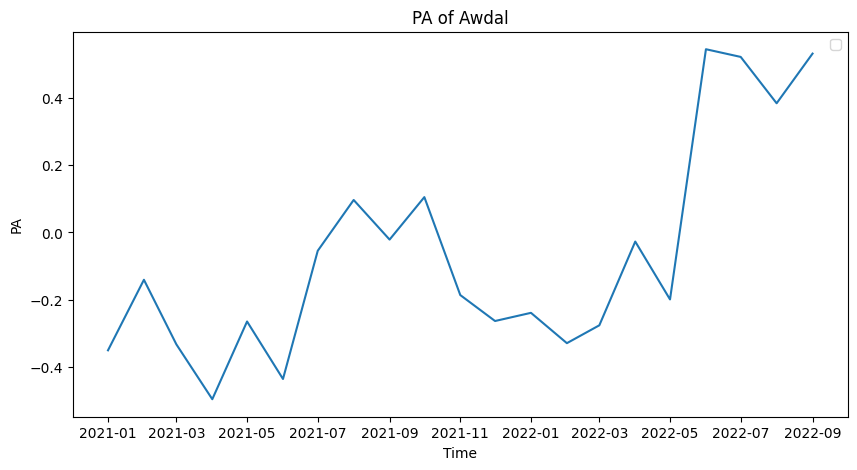

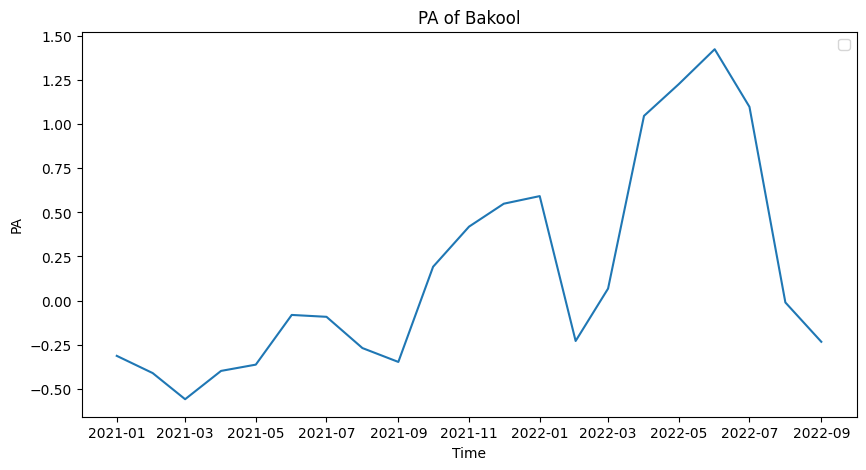

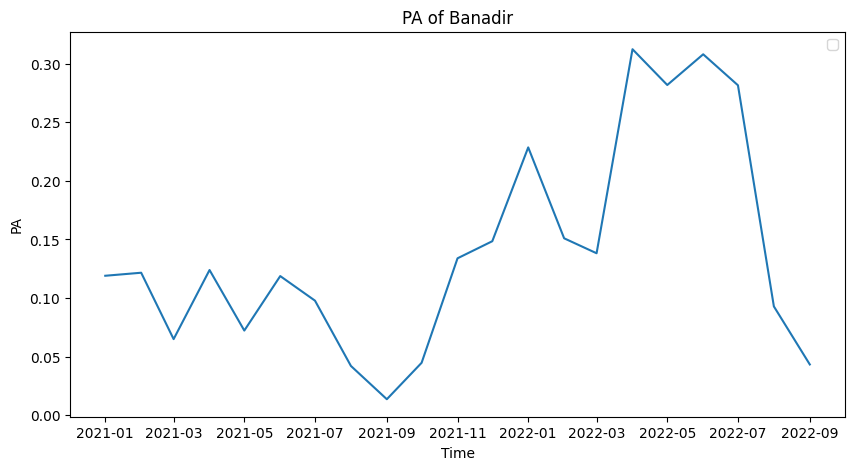

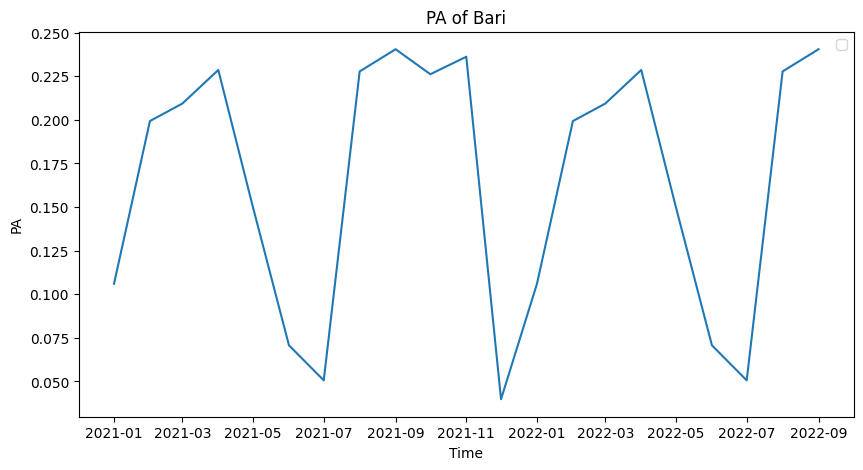

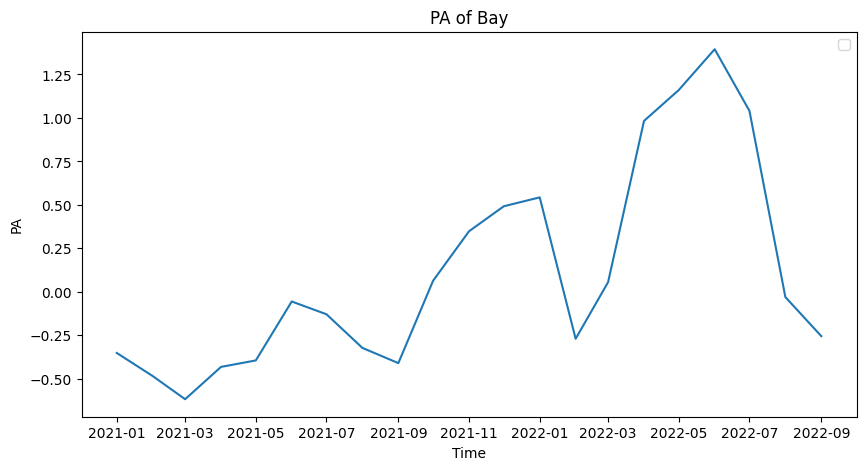

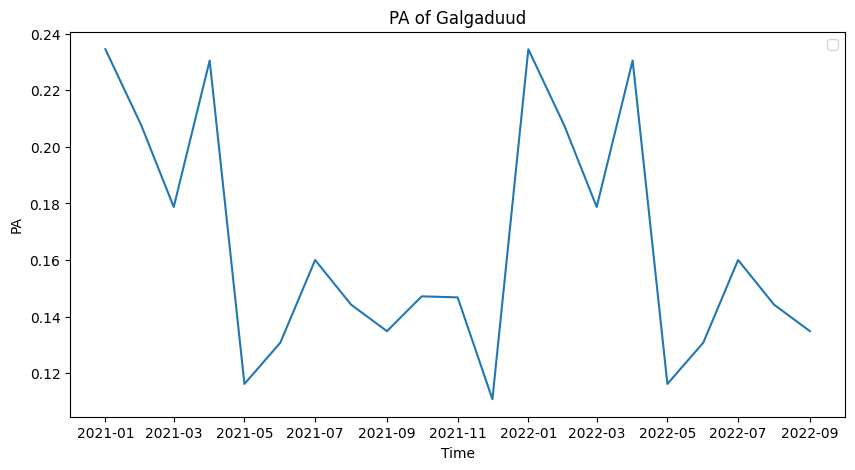

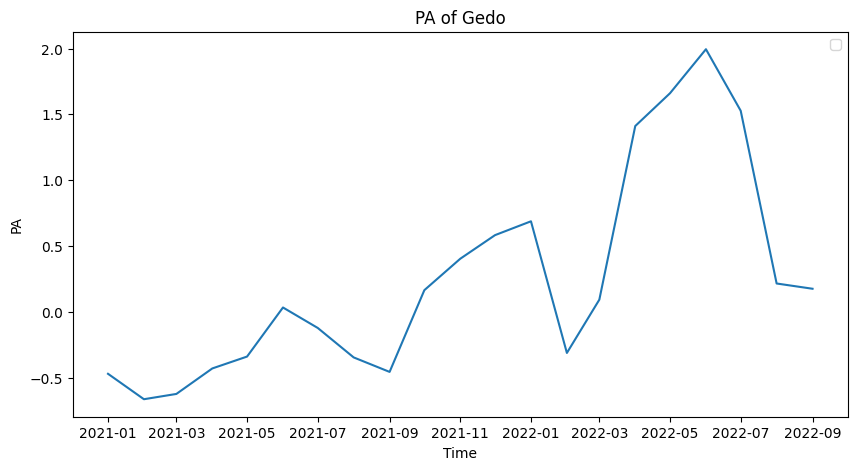

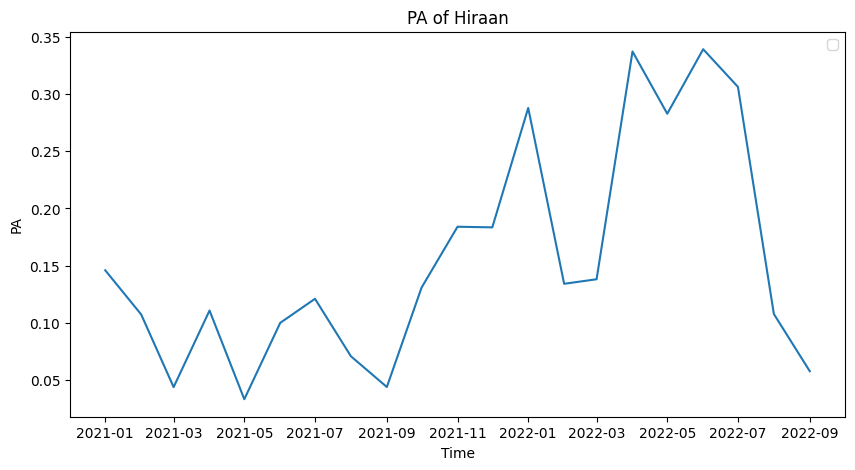

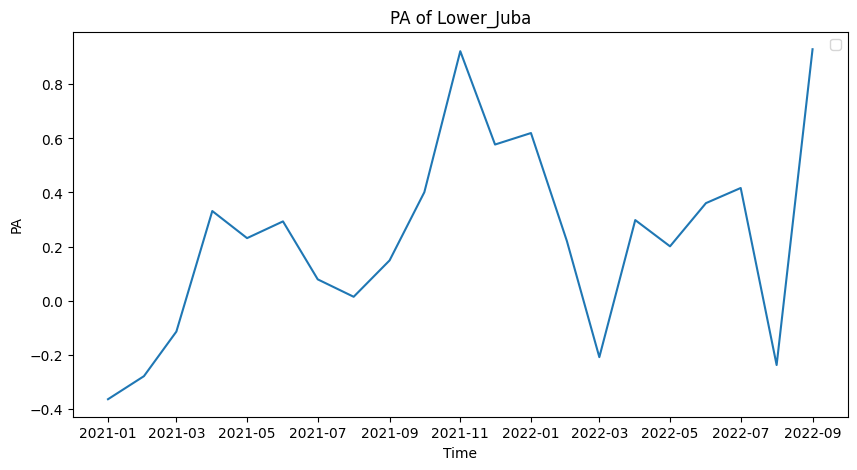

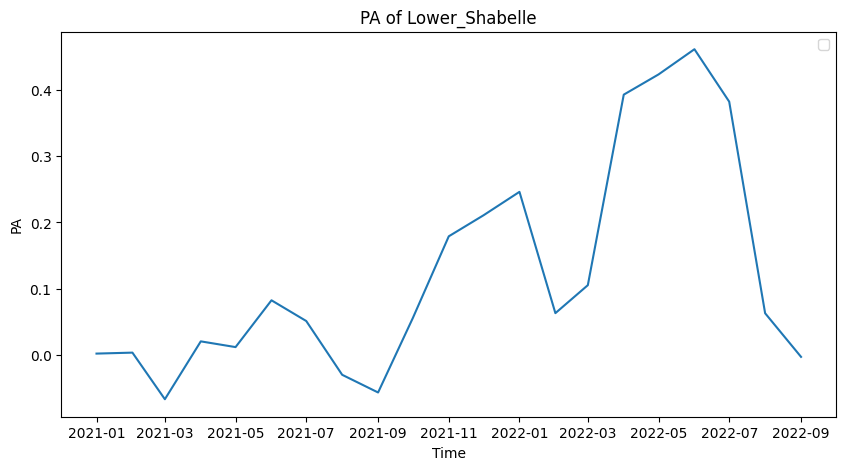

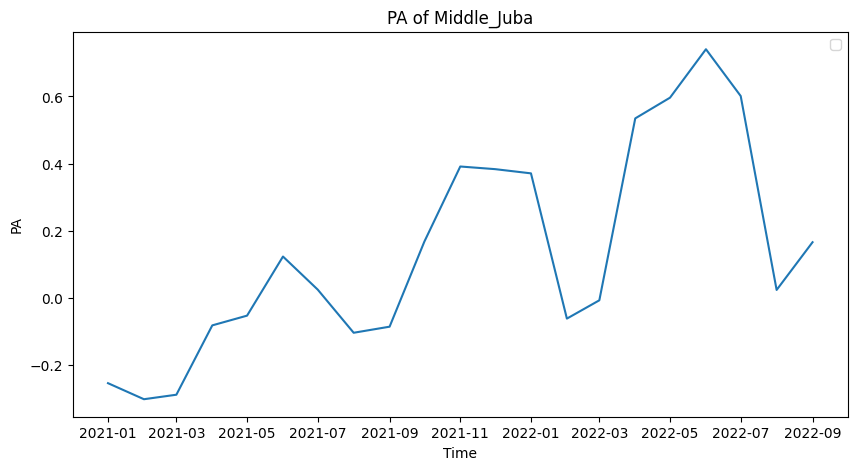

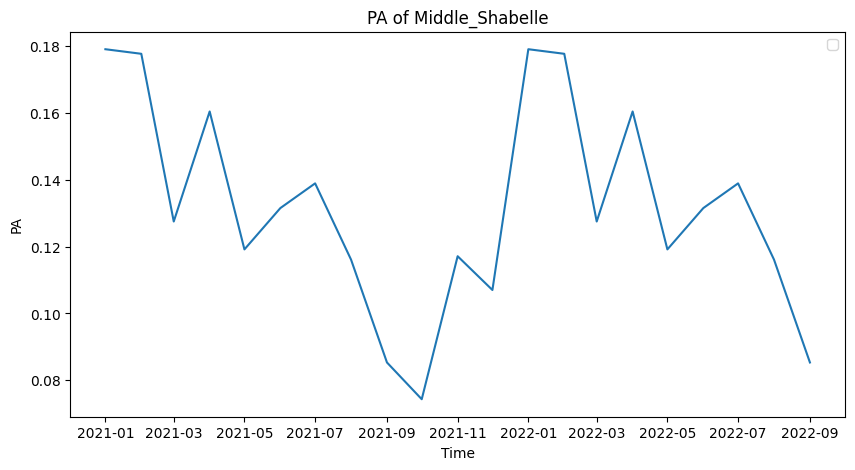

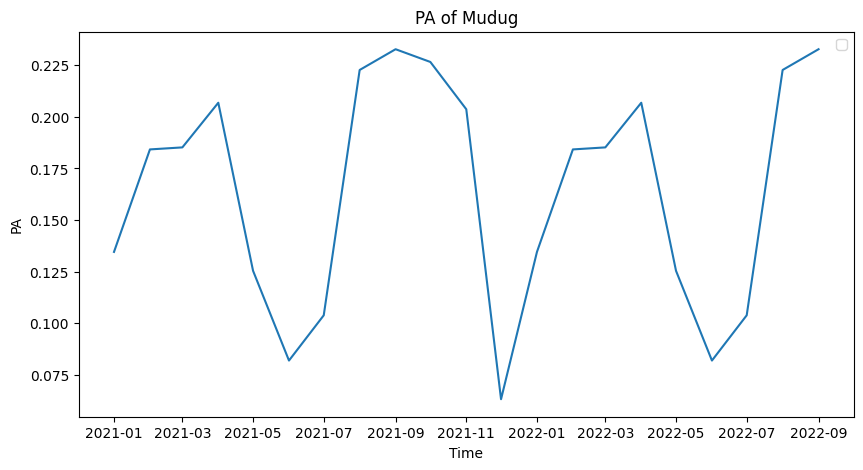

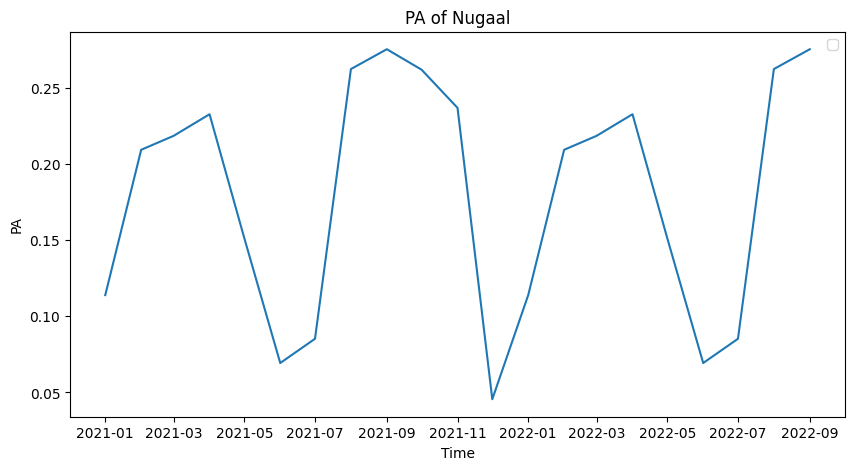

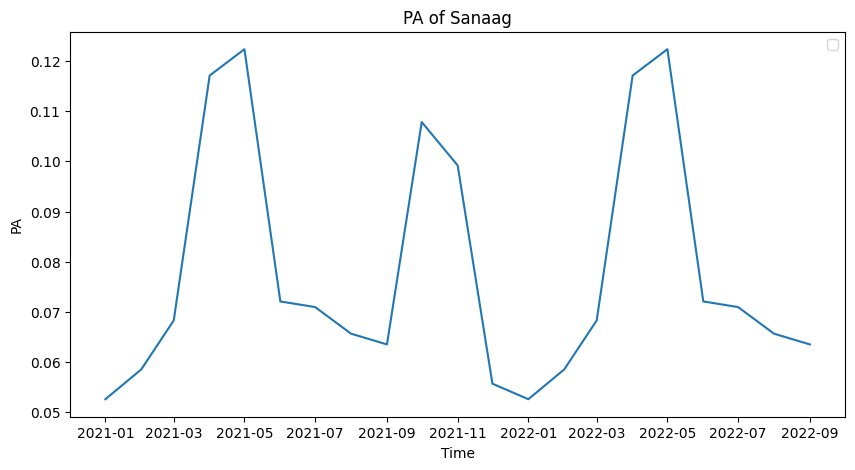

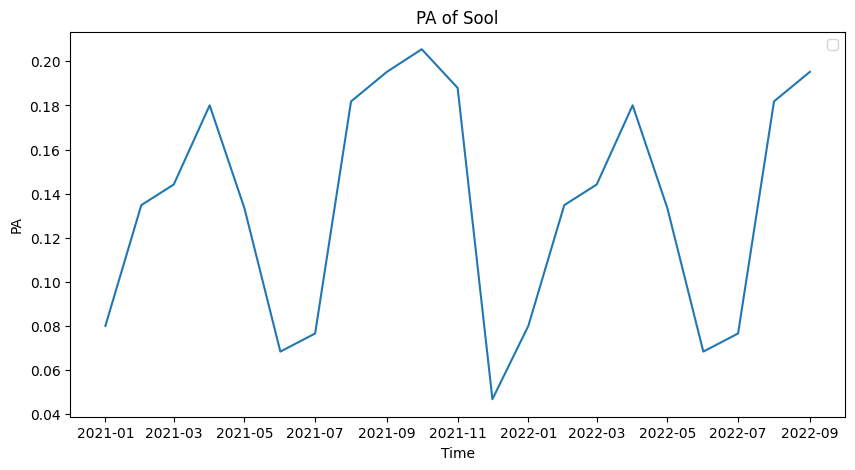

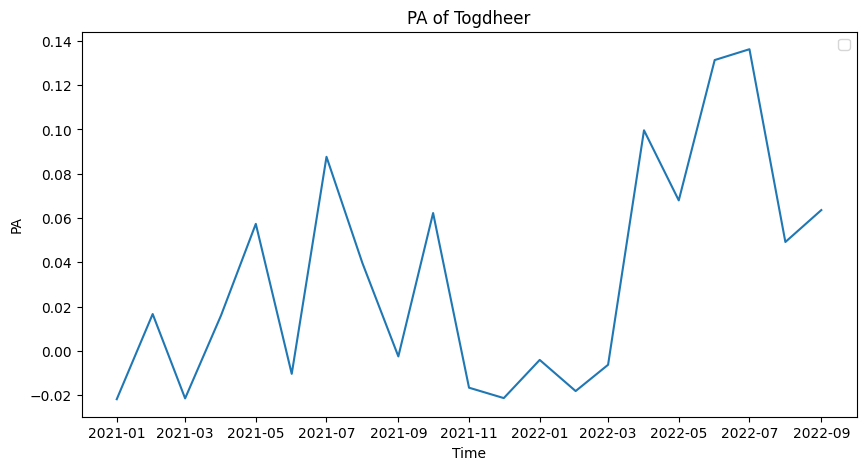

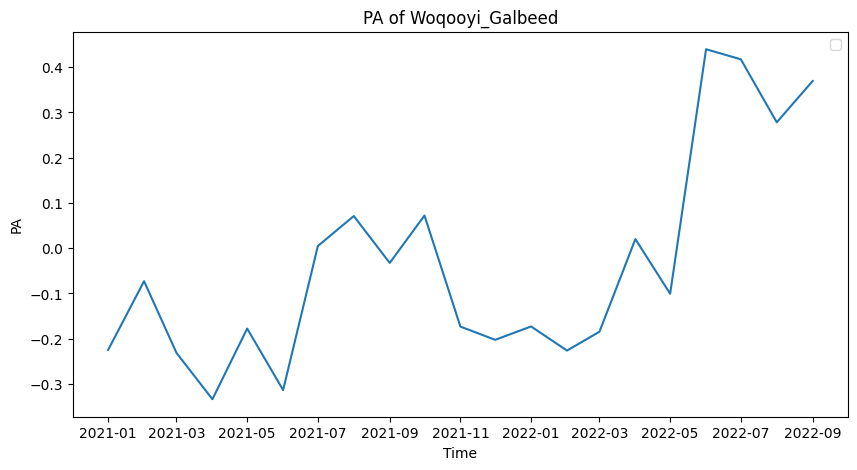

In [23]:
df_with_dummies = df_with_dummies[df_with_dummies['time']>='2021-01']
df_with_dummies = df_with_dummies[df_with_dummies['time']<='2022-09']
for reg in df_with_dummies['admin1'].unique():
    ban= df_with_dummies[df_with_dummies['admin1']==reg]
    #plot timeseries of pre 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(pd.to_datetime(ban['time']), ban['PA'])
    ax.set_xlabel("Time")
    ax.set_ylabel("PA")
    ax.set_title("PA of " + reg)
    ax.legend()
plt.show()